This notebook will take a few gigs -- so make sure you have Docker set to allow at least 4G of RAM -- and that you have 4G of RAM!

Now something completely different -- street signs. This is a bit more real world machine vision problem as it relates to self driving cars. Lots more to self driving cars than just signs -- but you need to understand the signs!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, MaxPooling2D, MaxPooling1D, Conv2D, Reshape, Dropout
from keras.layers import BatchNormalization, ZeroPadding2D
from keras.models import Model, Sequential
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import csv
import zipfile
from skimage.transform import resize
from sklearn.metrics import classification_report

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Download signs data. This uses a bit of under the hood keras to locally cache the files.

In [2]:
training_path = keras.utils.data_utils.get_file('training.zip',
    origin='http://benchmark.ini.rub.de/Dataset/GTSRB-Training_fixed.zip')
testing_path = keras.utils.data_utils.get_file('testing.zip',
    origin='http://benchmark.ini.rub.de/Dataset/GTSRB_Online-Test-Images.zip')
testing_classes_path = keras.utils.data_utils.get_file('testing_classes.zip',
    origin='http://benchmark.ini.rub.de/Dataset/GTSRB_Online-Test-GT.zip')

106496/104454 [==============================] - 1s 5us/step


These are zip files full of images, so we'll need to do some pre-processing. Need to create an (image, x, y, color) dataset of all the images, and an (image, one-hot-class) dataset of all the labels.

In [3]:
def read_image(path_to_image):
    raw_image_matrix = plt.imread(path_to_image)
    image_matrix = resize(raw_image_matrix, (32, 32), mode='constant')
    return image_matrix

def read_train_images(path_to_zip_file):
    extract_to = '{0}.d'.format(path_to_zip_file)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    images = [] # images
    labels = [] # corresponding labels
    # loop over all numbered classes
    for c in range(0, 43):
        prefix = '{0}/GTSRB/Training/{1}/'.format(extract_to, format(c, '05d'))
        with open('{0}GT-{1}.csv'.format(prefix, format(c, '05d'))) as image_annotations:
            gtReader = csv.reader(image_annotations, delimiter=';')
            next(gtReader) # skip header
            for image_data in gtReader:
                # the 1th column is the filename
                images.append(read_image('{0}{1}'.format(prefix, image_data[0]))) 
                # the 8th column is the label
                labels.append(image_data[7]) 

    return np.asarray(images), keras.utils.to_categorical(labels, 43)

In [4]:
train_images, train_labels = read_train_images(training_path)

Let's take a peek at these images and get a sense of the shape.

(26640, 32, 32, 3)

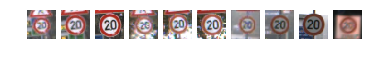

In [5]:
fig = plt.figure()
for i in range(0, 10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(train_images[i*10])
    plt.axis('off')
train_images.shape

Unfortunately -- the directory structure is different for the training data, so we'll have some mildly repetetive code.

In [6]:
def read_test_images(testing_path, testing_classes_path):
    images = [] # images
    labels = [] # corresponding labels
    
    extract_classes_to = '{0}.d/'.format(testing_classes_path)
    with zipfile.ZipFile(testing_classes_path, 'r') as zip_ref:
        zip_ref.extractall(extract_classes_to)
        
    extract_images_to = '{0}.d/'.format(testing_path)
    with zipfile.ZipFile(testing_path, 'r') as zip_ref:
        zip_ref.extractall(extract_images_to)
        
    prefix = '{0}/GTSRB/Online-Test/Images/'.format(extract_images_to)
        
    with open('{0}GT-online_test.csv'.format(extract_classes_to)) as image_annotations:
        gtReader = csv.reader(image_annotations, delimiter=';')
        next(gtReader) # skip header
        for image_data in gtReader:
            # the 1th column is the filename
            images.append(read_image('{0}{1}'.format(prefix, image_data[0]))) 
            # the 8th column is the label
            labels.append(image_data[7]) 
            
    return np.asarray(images), keras.utils.to_categorical(labels, 43)

In [7]:
test_images, test_labels = read_test_images(testing_path, testing_classes_path)

OK -- now with our testing and training data in hand, let's make some models, starting with a straightforward ConvNet, then we'll move on to some more complex models and compare their accuracy!

In [8]:
number_of_classes = 43
batch_size = 32

In [9]:
input_shape = train_images[0].shape


model = Sequential()
model.add(Reshape(input_shape, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=8,
          validation_data=(test_images, test_labels))

Train on 26640 samples, validate on 12569 samples
Epoch 1/8
26640/26640 [==============================] - 11s 428us/step - loss: 0.7649 - acc: 0.7945 - val_loss: 0.4082 - val_acc: 0.8986
Epoch 2/8
26640/26640 [==============================] - 8s 299us/step - loss: 0.1140 - acc: 0.9696 - val_loss: 0.3561 - val_acc: 0.9102
Epoch 3/8
26640/26640 [==============================] - 8s 301us/step - loss: 0.0637 - acc: 0.9822 - val_loss: 0.2556 - val_acc: 0.9363
Epoch 4/8
26640/26640 [==============================] - 8s 295us/step - loss: 0.0338 - acc: 0.9914 - val_loss: 0.4783 - val_acc: 0.8994
Epoch 5/8
26640/26640 [==============================] - 8s 299us/step - loss: 0.0420 - acc: 0.9877 - val_loss: 0.3453 - val_acc: 0.9267
Epoch 6/8
26640/26640 [==============================] - 8s 298us/step - loss: 0.0273 - acc: 0.9929 - val_loss: 0.3189 - val_acc: 0.9239
Epoch 7/8
26640/26640 [==============================] - 8s 292us/step - loss: 0.0237 - acc: 0.9941 - val_loss: 0.2977 - val_ac

Let's take a look at a classification report and see how well we are balanced in our predictions.

In [10]:
y_true, y_pred = np.argmax(test_labels, axis=1), np.argmax(model.predict(test_images), axis=1)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.68      0.81        60
          1       0.89      0.97      0.93       720
          2       0.99      0.90      0.94       750
          3       0.98      0.92      0.95       450
          4       0.94      0.92      0.93       660
          5       0.90      0.93      0.91       600
          6       0.93      0.94      0.94       120
          7       0.95      0.98      0.97       480
          8       0.96      0.90      0.93       450
          9       0.90      0.99      0.94       480
         10       1.00      0.92      0.96       660
         11       0.91      0.94      0.93       420
         12       0.81      1.00      0.89       690
         13       1.00      0.94      0.97       720
         14       0.88      0.97      0.92       240
         15       0.88      0.91      0.90       210
         16       0.98      1.00      0.99       120
         17       0.98      0.92      0.95   

Good news -- that is fairly balanced -- but it is clearly overfit! Let's use what we've learned about normalization and regularization to make it more accurate. 

Let's add in Dropout to regularize the network -- the goal here being to narrow the gap between training and validation accuracy.

In [11]:
dropout = 0.25

model = Sequential()
model.add(Reshape(input_shape, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(dropout))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(dropout))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(number_of_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=8,
          validation_data=(test_images, test_labels))

Train on 26640 samples, validate on 12569 samples
Epoch 1/8
26640/26640 [==============================] - 10s 378us/step - loss: 1.6474 - acc: 0.5245 - val_loss: 0.6239 - val_acc: 0.8487
Epoch 2/8
26640/26640 [==============================] - 9s 347us/step - loss: 0.5358 - acc: 0.8289 - val_loss: 0.3423 - val_acc: 0.9111
Epoch 3/8
26640/26640 [==============================] - 9s 340us/step - loss: 0.3484 - acc: 0.8902 - val_loss: 0.2957 - val_acc: 0.9283
Epoch 4/8
26640/26640 [==============================] - 9s 345us/step - loss: 0.2527 - acc: 0.9200 - val_loss: 0.1989 - val_acc: 0.9449
Epoch 5/8
26640/26640 [==============================] - 9s 341us/step - loss: 0.2036 - acc: 0.9334 - val_loss: 0.2143 - val_acc: 0.9433
Epoch 6/8
26640/26640 [==============================] - 9s 341us/step - loss: 0.1776 - acc: 0.9443 - val_loss: 0.1851 - val_acc: 0.9470
Epoch 7/8
26640/26640 [==============================] - 9s 339us/step - loss: 0.1479 - acc: 0.9528 - val_loss: 0.1767 - val_ac

Now let's add in a bit of normalization for each batch.

In [12]:
dropout = 0.25

model = Sequential()
model.add(Reshape(input_shape, input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(dropout))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(dropout))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(number_of_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=8,
          validation_data=(test_images, test_labels))

Train on 26640 samples, validate on 12569 samples
Epoch 1/8
26640/26640 [==============================] - 11s 415us/step - loss: 1.3140 - acc: 0.6208 - val_loss: 0.4030 - val_acc: 0.9054
Epoch 2/8
26640/26640 [==============================] - 10s 378us/step - loss: 0.3364 - acc: 0.8971 - val_loss: 0.2092 - val_acc: 0.9487
Epoch 3/8
26640/26640 [==============================] - 10s 382us/step - loss: 0.2044 - acc: 0.9382 - val_loss: 0.1748 - val_acc: 0.9527
Epoch 4/8
26640/26640 [==============================] - 10s 381us/step - loss: 0.1576 - acc: 0.9512 - val_loss: 0.1973 - val_acc: 0.9492
Epoch 5/8
26640/26640 [==============================] - 10s 383us/step - loss: 0.1296 - acc: 0.9609 - val_loss: 0.2198 - val_acc: 0.9485
Epoch 6/8
26640/26640 [==============================] - 10s 388us/step - loss: 0.1160 - acc: 0.9641 - val_loss: 0.1491 - val_acc: 0.9601
Epoch 7/8
26640/26640 [==============================] - 10s 377us/step - loss: 0.1059 - acc: 0.9673 - val_loss: 0.1250 - 

Aha -- now that moved the needle a bit, and it is clearly still learning as the loss keeps coming down. So, the next thing to do is -- train more!

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=32,
          validation_data=(test_images, test_labels))

Train on 26640 samples, validate on 12569 samples
Epoch 1/32
26640/26640 [==============================] - 11s 422us/step - loss: 0.0865 - acc: 0.9750 - val_loss: 0.1418 - val_acc: 0.9631
Epoch 2/32
26640/26640 [==============================] - 10s 381us/step - loss: 0.0760 - acc: 0.9767 - val_loss: 0.1830 - val_acc: 0.9593
Epoch 3/32
26640/26640 [==============================] - 10s 388us/step - loss: 0.0694 - acc: 0.9799 - val_loss: 0.1473 - val_acc: 0.9632
Epoch 4/32
26640/26640 [==============================] - 10s 388us/step - loss: 0.0715 - acc: 0.9796 - val_loss: 0.1474 - val_acc: 0.9602
Epoch 5/32
26640/26640 [==============================] - 10s 387us/step - loss: 0.0597 - acc: 0.9824 - val_loss: 0.1463 - val_acc: 0.9686
Epoch 6/32
26640/26640 [==============================] - 10s 394us/step - loss: 0.0609 - acc: 0.9821 - val_loss: 0.1387 - val_acc: 0.9665
Epoch 7/32
26640/26640 [==============================] - 10s 384us/step - loss: 0.0630 - acc: 0.9818 - val_loss: 0.

Aha -- we probably should have ended at the 27th epoch, but that can be accomodated by saving the model on each loop. But here we have a much narrower accuracy gap -- less overfitting!

In [14]:
y_true, y_pred = np.argmax(test_labels, axis=1), np.argmax(model.predict(test_images), axis=1)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.88      0.93        60
          1       0.97      0.97      0.97       720
          2       0.93      0.99      0.96       750
          3       0.97      1.00      0.98       450
          4       1.00      0.93      0.96       660
          5       0.96      0.96      0.96       600
          6       1.00      0.99      1.00       120
          7       0.95      0.99      0.97       480
          8       0.97      0.99      0.98       450
          9       0.96      0.99      0.97       480
         10       1.00      1.00      1.00       660
         11       0.97      0.97      0.97       420
         12       1.00      0.99      0.99       690
         13       0.99      1.00      1.00       720
         14       1.00      0.97      0.99       240
         15       0.97      0.94      0.95       210
         16       0.99      1.00      1.00       120
         17       0.99      1.00      0.99   